# Post-processing of micromagnetic simulations in MuMax³: Nanotrack and Nanodisk



# -> Plotting the trajectory of the skyrmion


Using the command mumax3-convert -comp z -color "blue,white,red" -png *.ovf, the .ovf files are converted into .png images, which are used to plot the trajectory of the skyrmion's center of mass along the nanotrack. In this scheme, blue represents the background material, while red and white represent the skyrmion core. Furthermore, it is possible to generate a video of the simulation using cv2.VideoWriter.To track the skyrmion core, pixels with red intensity above 50 are set to white, while those below 50 are set to black (discarded), as described by the thresholding function:$$d(x,y) = \begin{cases} 255 & \text{if } s(x,y) > 50 \\ 0 & \text{otherwise} \end{cases}$$Through cv2.moments, we calculate the image moments (weighted average of pixel intensities). In this script, the variable M is a dictionary containing geometric information about the white pixels, such as the area. The moment $m_{00}$ represents the total area of all white pixels; therefore, if $m_{00}$ is zero, we are accounting for a purely black image (which is discarded, as it implies no skyrmion core was detected).To determine the position, M['m10'] represents the sum of pixel weights in the x-direction, and M['m01'] in the y-direction. Hence, the center of mass coordinates are calculated as cx = M['m10'] / M['m00'] and cy = M['m01'] / M['m00'].

Video salvo: skyrmion_nanotrack_video.mp4


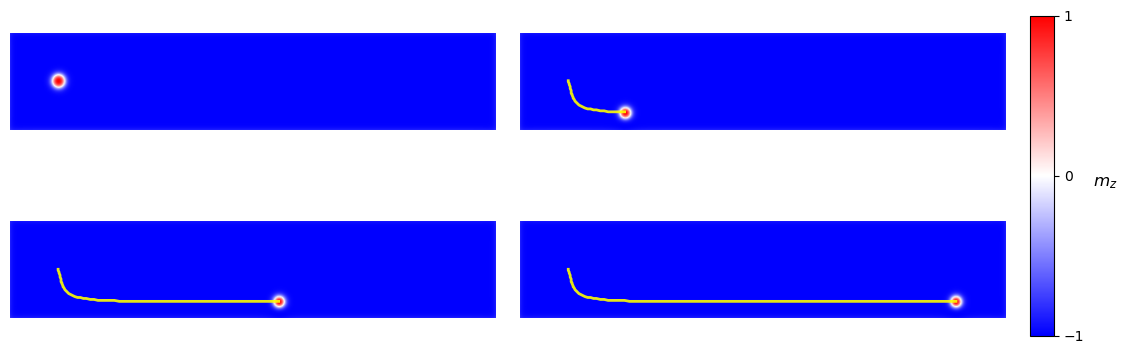

Video salvo: skyrmion_disk_video.mp4


In [ ]:
import cv2
import glob 
from natsort import natsorted
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors # color bar
import numpy as np


class SimulationVideoCreator():
    def __init__(self, input_folder, output_video, fps=30):
        self.input_folder = input_folder
        self.output_video = output_video
        self.fps = fps

    def sort_image_files(self):
        '''
        Sorts image files in the input folder in a natural order.
        '''
        return natsorted(glob.glob(self.input_folder))
    
    def create_video(self):
        '''
        Creates a video from a sequence of images in the specified input folder and saves it to the output video path.
        '''

        image_files = self.sort_image_files()

        if not image_files:
            print(f"Nenhuma imagem encontrada em {self.input_folder}")
            return

        first_frame = cv2.imread(image_files[0])
        height, width, layers = first_frame.shape
        video_writer = cv2.VideoWriter(self.output_video, cv2.VideoWriter_fourcc(*'mp4v'), self.fps, (width, height)) #fourcc code for mp4 format (fourcharacter code)

        for image_file in image_files:
            frame = cv2.imread(image_file) #Read the image file and store it in the variable 'frame'

            if frame is not None:
                video_writer.write(frame) # Write the frame to the video file using the video writer object
        video_writer.release() # Release the video writer object to finalize the video file and free up system resources.
        print(f"Video salvo: {self.output_video}")

class PlotTrajectory(SimulationVideoCreator):
    def __init__(self, input_folder):
            super().__init__(input_folder, output_video=None, fps=None)
        
    def detect_trajectory(self):
        files = self.sort_image_files()
        frames_to_plot = set(np.linspace(0 , len(files)-1, 4, dtype=int))  # Select 4 frames to plot the trajectory
        
        trajectory_x = []
        trajectory_y = []
        frames_positions = []

        for i, image_file in enumerate(files):
            frame = cv2.imread(image_file)
            if frame is None: continue

            red_nucleus = frame[:, :, 2] # Extract the red channel (nucleus of the skyrmion) ; 0: blue, 1: green, 2: red
            _, binary = cv2.threshold(red_nucleus, 50, 255, cv2.THRESH_BINARY) #binary: black and white
            M = cv2.moments(binary)
            
           
            cx, cy = None, None

            if M['m00'] != 0:
                cx = int(M['m10'] / M['m00' ]) # Calculate the x-coordinate of the center of mass of the binary image
                cy = int(M['m01'] / M['m00']) # Calculate the y-coordinate of the center of mass of the binary image
                trajectory_x.append(cx)
                trajectory_y.append(cy)
            else:
                pass
            

            if i in frames_to_plot: 
                frames_positions.append({
                    "Frame": i,
                    "image": frame, 
                    "traj_x": list(trajectory_x), 
                    "traj_y": list(trajectory_y) 
                })
        return frames_positions
    
    def plot_trajectory(self, frames_data, output_file):
        if not frames_data:
            print("Nenhum dado para plotar.")
            return
        
        fig, axs = plt.subplots(2, 2, figsize=(12, 4), frameon=False)
        axs = axs.ravel() 
        
        plot_counter = 0

 
        for data in frames_data:
            if plot_counter < 4:
                ax = axs[plot_counter]
                
                img = data['image']
                traj_x = data['traj_x']
                traj_y = data['traj_y']

                
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert the first frame from BGR to RGB color space
                ax.imshow(img_rgb) # Display the first frame on the first subplot
                
                # Plot the trajectory if there are valid coordinates
                if traj_x:
                     ax.plot(traj_x, traj_y, color='yellow', linewidth=2, alpha=0.9)

                ax.axis('off')
                plot_counter += 1
        
    
        plt.subplots_adjust(left=0.05, right=0.88, top=0.95, bottom=0.05, wspace=0.05, hspace=0.1)


        norm = mcolors.Normalize(vmin=-1, vmax=1)
        cmap = cm.bwr 
        mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
        mappable.set_array([])

 
        cbar_ax = fig.add_axes([0.90, 0.1, 0.02, 0.8]) 
        cbar = fig.colorbar(mappable, cax=cbar_ax)
        cbar.set_label('$m_z$', rotation=0, labelpad=15, fontsize=12)
        cbar.set_ticks([-1, 0, 1]) 

      
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.show() 
        plt.close() 

      
if __name__ == "__main__":

    input_folder1 = '/home/jfelipe/TCC/nano_pista_semdemag.out/coloridos/*.png' 
    input_folder2 = '/home/jfelipe/TCC/nano_disco_semdemag.out/coloridos/*.png' 
    
    output_video1 = 'skyrmion_nanotrack_video.mp4'
    output_video2 = 'skyrmion_disk_video.mp4'


    output_plot1 = 'nanotrack.png'

    # --- Nanotrack ---
    video_creator1 = SimulationVideoCreator(input_folder1, output_video1, fps=30)
    video_creator1.create_video()
    
    plotter1 = PlotTrajectory(input_folder1)
    dados_pista = plotter1.detect_trajectory()
    plotter1.plot_trajectory(dados_pista, output_plot1)

    # --- DISK ---
    video_creator2 = SimulationVideoCreator(input_folder2, output_video2, fps=30)
    video_creator2.create_video()
    


# -> Solving the Thiele Equation using micromagnetic simulations data